<a href="https://colab.research.google.com/github/chemoinformatics-lecture/lecture-beginner/blob/main/lesson07_automl/lecture_note_regression_colab_pycaret31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.1 ライブラリーのインストール

In [1]:
!pip install pycaret==3.1.0
!pip install shap==0.43
!pip install rdkit==2022.3.5

# 0.2 ライブラリーのインポートとバージョンの確認

In [2]:
import pycaret
pycaret.__version__

'3.1.0'

In [3]:
import sklearn
print(sklearn.__version__)

1.2.2


In [4]:
import pandas as pd
pd.__version__

'1.5.3'

In [5]:
import shap
shap.__version__

'0.43.0'

In [6]:
from rdkit import rdBase
rdBase.rdkitVersion

'2022.03.5'

# 1. データのセットアップ

In [7]:
!wget 'http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat'

--2023-11-04 01:21:06--  http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat
Resolving modem.ucsd.edu (modem.ucsd.edu)... 132.239.68.159
Connecting to modem.ucsd.edu (modem.ucsd.edu)|132.239.68.159|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52906 (52K) [text/plain]
Saving to: ‘data_set.dat.1’

data_set.dat.1      100%[===================>]  51.67K   153KB/s    in 0.3s    

2023-11-04 01:21:06 (153 KB/s) - ‘data_set.dat.1’ saved [52906/52906]



In [8]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools
import numpy as np

# データの呼び出しなど
df = pd.read_csv('data_set.dat', sep='\t', header=None, names = ["smiles", "CAS", "logS"])
PandasTools.AddMoleculeColumnToFrame(df, "smiles")
df = df.dropna(subset=['ROMol'], axis=0)
df = df.reset_index()

# fingerprintの作成
fingerprints = []
safe = []
for mol_idx, mol in enumerate(df["ROMol"]):
    try:
        fingerprint = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)]
        fingerprints.append(fingerprint)
        safe.append(mol_idx)

    except:
        print("Error", mol_idx)
        continue
fingerprints = np.array(fingerprints)
df_fp = pd.DataFrame(fingerprints)

# dfをあわせて表示
df_comb = pd.merge(df, df_fp, left_index=True, right_index=True)

,index,smiles,CAS,logS,ROMol,0,1,2,3,4,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,O=C(C)N,60-35-5,1.58,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0

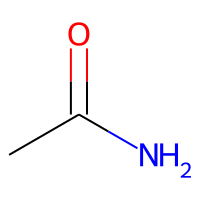

In [9]:
df_comb.head(1)

In [10]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_comb, test_size = 0.1, random_state = 10)

,index,smiles,CAS,logS,ROMol,0,1,2,3,4,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,O=C(C)N,60-35-5,1.58,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0

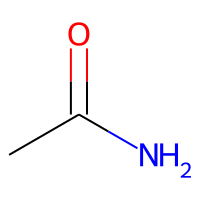

In [11]:
df_train.sort_index().head(1)

,index,smiles,CAS,logS,ROMol,0,1,2,3,4,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
7,7,[nH0]1cccc[nH0]1,289-80-5,1.1,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0

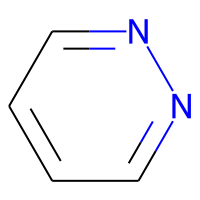

In [12]:
df_test.sort_index().head(1)

In [13]:
from pycaret.regression import *
exp1 = setup(df_train, target = 'logS', ignore_features= ['index', 'smiles', 'CAS', 'ROMol'], fold_shuffle=True, session_id=123, test_data=df_test)

,Description,Value
0,Session id,123
1,Target,logS
2,Target type,Regression
3,Original data shape,"(1289, 2053)"
4,Transformed data shape,"(1289, 2049)"
5,Transformed train set shape,"(1160, 2049)"
6,Transformed test set shape,"(129, 2049)"
7,Ignore features,4
8,Numeric features,2048
9,Preprocess,True


# 2. compare_models

In [14]:
best = compare_models(fold=3) # デフォルトは、foldが10。交差検証の数です。小さくすると短い時間で終わりますが、データ検証としては不十分なときも。

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.8387,1.2754,1.1292,0.6854,0.3245,0.9873,1.1100
xgboost,Extreme Gradient Boosting,0.8478,1.3079,1.1435,0.6776,0.3283,1.0440,1.7367
lightgbm,Light Gradient Boosting Machine,0.8899,1.3644,1.1679,0.6645,0.3342,1.0146,1.3833
rf,Random Forest Regressor,0.8713,1.3642,1.1678,0.6636,0.3228,1.1416,6.5233
ridge,Ridge Regression,0.9055,1.5112,1.2292,0.6273,0.3525,0.9285,0.4100
gbr,Gradient Boosting Regressor,0.9511,1.5334,1.2382,0.6228,0.3394,1.3622,1.8200
huber,Huber Regressor,0.9639,1.6999,1.3037,0.5804,0.3692,0.9017,1.8533
et,Extra Trees Regressor,1.0447,1.9665,1.4011,0.5170,0.3910,1.1605,10.2200
knn,K Neighbors Regressor,1.0880,2.0360,1.4262,0.4977,0.4064,1.2645,0.3833
par,Passive Aggressive Regressor,1.0915,2.1730,1.4739,0.4633,0.4141,1.3377,0.4033


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

# 3. 分析モデルの生成： create_model()

In [15]:
#どんなモデルが入っているかを確認できる。
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [16]:
# compare_modelsでベストでなくても、名前を設定すると、そのモデルを作成してくれます。予めモデルが決まっているときも便利です。
lr = create_model('xgboost')
# models()で表示させたID名を指定します。

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8314,1.3499,1.1618,0.6501,0.3097,0.6003
1,0.7899,1.1038,1.0506,0.7059,0.3154,1.9856
2,0.8430,1.4618,1.2091,0.6945,0.3292,1.7774
3,0.8302,1.2658,1.1251,0.7486,0.3046,0.8204
4,0.8531,1.1155,1.0562,0.6753,0.3296,1.1249
5,0.7458,0.9629,0.9813,0.7505,0.2820,1.0313
6,0.7935,1.1462,1.0706,0.7413,0.3186,1.5291
7,0.7778,1.0453,1.0224,0.7107,0.3056,0.8154
8,0.8410,1.2626,1.1236,0.6765,0.2956,0.3896


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

# 4. チューニング： tune_model()

In [17]:
# モデルをチューニングしていきます。 compare_modelsで得られたbestで指定するか、create_modelで作成したlrを指定します。
tuned_lr = tune_model(lr, optimize = "R2", fold = 3, n_iter = 3)
# デフォルトは、optimize = "R2", foldが10, n_iterのデフォルトは10。

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9941,1.6559,1.2868,0.6083,0.3496,1.5945
1,0.9967,1.6628,1.2895,0.6135,0.3556,1.2918
2,0.9525,1.6338,1.2782,0.5586,0.3364,0.9744
Mean,0.9811,1.6508,1.2848,0.5935,0.3472,1.2869
Std,0.0202,0.0124,0.0048,0.0247,0.0080,0.2532


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 3 candidates, totalling 9 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [18]:
print("tuning前")
print(lr)
print("tuning後")
print(tuned_lr)

tuning前
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=123, ...)
tuning後
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=Fal

# 5. 可視化： plot_model()

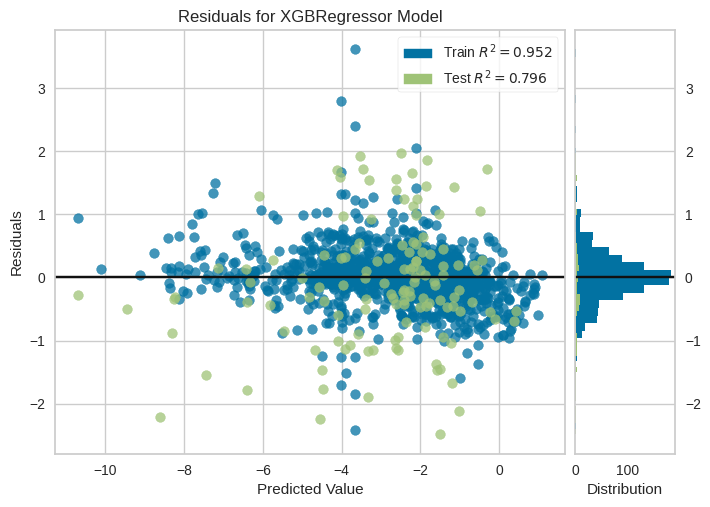

In [19]:
#  残差（residual）とは、観測された値と予測値との差の算出
plot_model(tuned_lr, plot='residuals')

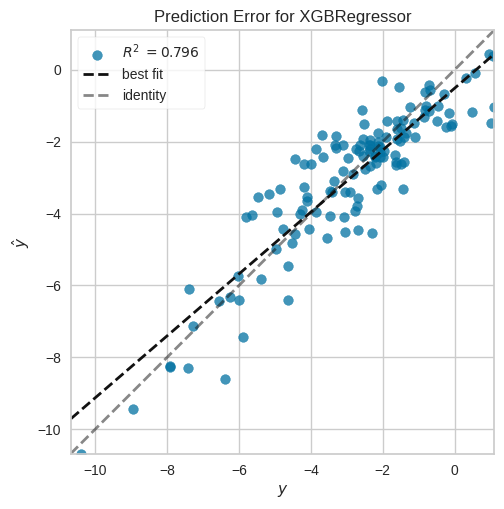

In [20]:
# 誤差プロット
plot_model(tuned_lr, plot="error")

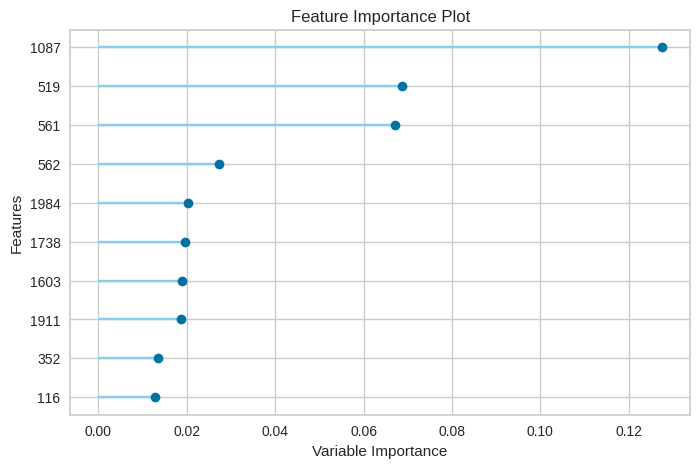

In [21]:
# 特徴量重要度 (表示できるものとできないものがある)
plot_model(tuned_lr, plot="feature")

# 6. 評価： evaluate_model()

In [22]:
# plot_model()で得られるものの他、色々なものを一度に出力してくれる。
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# 7. 予測： finalize_model(), predict_model()

In [23]:
# トレーニングデータを全て使って訓連することができる。
final_lr = finalize_model(tuned_lr)

In [24]:
test_predictions = predict_model(final_lr)
test_predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.2883,0.1417,0.3764,0.9683,0.1331,0.2619


,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,logS,prediction_label
1256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-6.02,-6.037370
142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.80,-0.558170
689,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-4.19,-3.926398
989,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.45,-1.460852
124,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.70,-0.578985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-2.56,-2.521001
225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.40,-2.265162
375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-2.16,-1.904751
411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-2.35,-1.808382


In [25]:
train_data = predict_model(final_lr, data = df_train)
test_data = predict_model(final_lr, data = df_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.3156,0.2025,0.4500,0.9505,0.1510,0.4379


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.2883,0.1417,0.3764,0.9683,0.1331,0.2619


,index,smiles,CAS,logS,ROMol,0,1,2,3,4,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,prediction_label
1256,1257,c1c(Cl)cc(c(c1)Cl)c1ccccc1Cl,37680-65-2,-6.02,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-6.03737

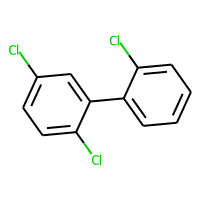

In [26]:
df_test["prediction_label"] = test_data["prediction_label"]
df_test.head(1)

,index,smiles,CAS,logS,ROMol,0,1,2,3,4,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,prediction_label
373,374,C1C=CC=CC=C1,544-25-2,-2.15,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.993279

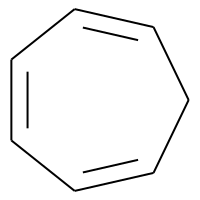

In [27]:
df_train["prediction_label"] = train_data["prediction_label"]
df_train.head(1)

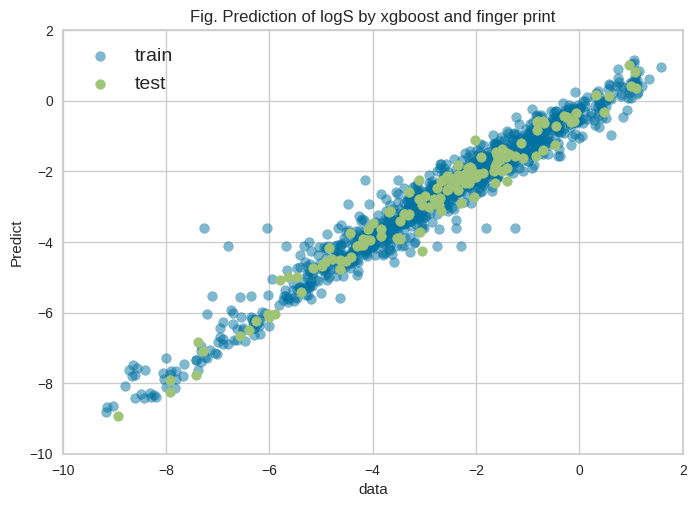

In [28]:
# グラフ作成をmatplotlibで行う
import matplotlib.pyplot as plt

# 得られた学習結果と実験値とを比較する。
plt.figure()

# トレーニングデータのプロット
x１ = train_data["logS"]
y1 = train_data["prediction_label"]

plt.scatter(x1, y1, alpha=0.5, label="train") # alphaを入れると薄くなる。

# テストデータのプロット
x2 = test_data["logS"]
y2 = test_data["prediction_label"]

plt.scatter(x2, y2, label="test")

# 範囲の指定
plt.xlim(-10, 2)
plt.ylim(-10, 2)

# タイトルを入れる。
plt.title("Fig. Prediction of logS by xgboost and finger print")

# X軸とY軸にラベルを作成
plt.xlabel('data')
plt.ylabel('Predict')

# 凡例の場所を指定
plt.legend(loc="upper left", fontsize=14)

# 表示させる
plt.show()

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_test = x2
y_pred_test = y2

# MAE（Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred_test)
print(f'mae:{mae:.4f}')
# MAPE(Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f'mape:{mape:.4f}')
# SMAPE(Symmetric Mean Absolute Percentage Error)
smape = 100/len(y_test) * np.sum(2 * np.abs(y_pred_test - y_test) / (np.abs(y_pred_test) + np.abs(y_test)))
print(f'smape:{smape:.4f}')
# mse (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred_test)
print(f'mse:{mse:.4f}')
# rmse (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f'rmse: {rmse:.4f}')
# R2
score2 = r2_score(y_test, y_pred_test)
print("R2", score2)

mae:0.2883
mape:26.1895
smape:19.6259
mse:0.1417
rmse: 0.3764
R2 0.9683489413600586


In [30]:
save_model(final_lr, 'my_best_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29', ...],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(st...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
    

In [31]:
#load_modelで呼び出せる。
loaded_model = load_model('my_best_pipeline')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['0', '1', '2', '3', '4', '5', '6',
                                             '7', '8', '9', '10', '11', '12',
                                             '13', '14', '15', '16', '17', '18',
                                             '19', '20', '21', '22', '23', '24',
                                             '25', '26', '27', '28', '29', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=Simpl...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max

# 以上です。

# 補足説明(shap)

## 全体の傾向

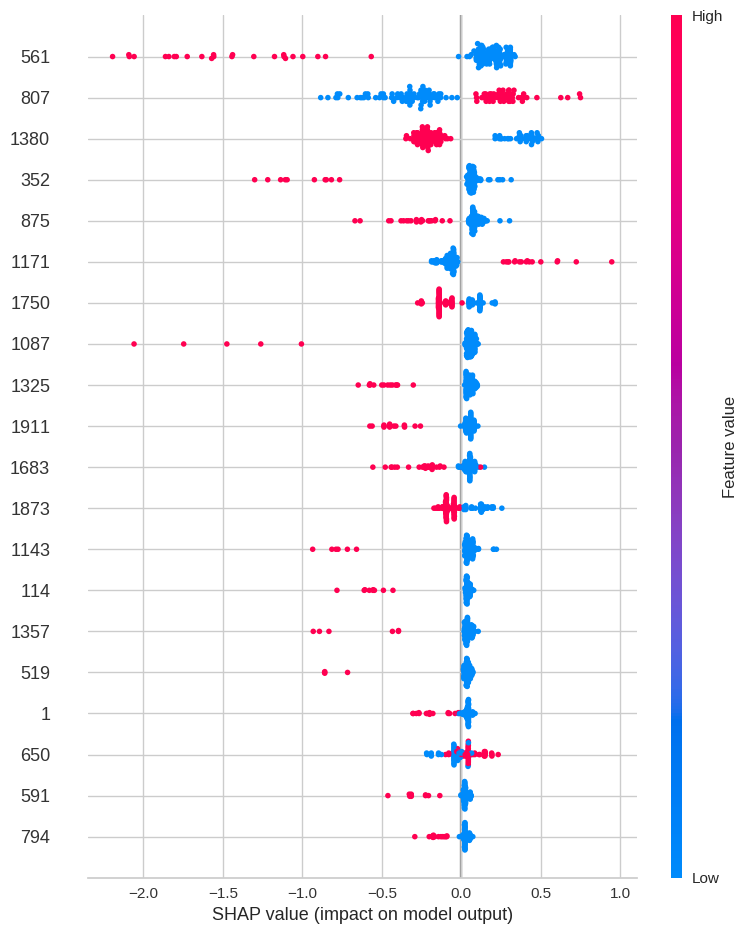

In [34]:
interpret_model(tuned_lr)

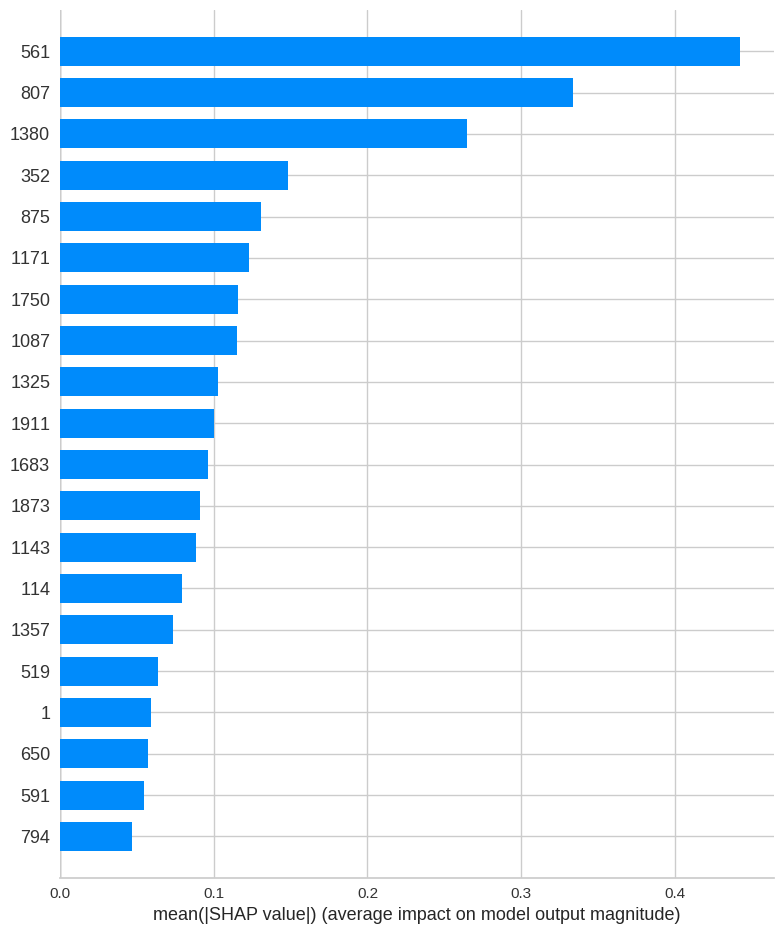

In [36]:
interpret_model(tuned_lr,plot_type='bar')

## 個別の解析

In [35]:
interpret_model(tuned_lr,plot='reason', observation=0)